# Setup

In [1]:
import numpy as np
import tensorflow as tf
import json
from matplotlib import pyplot as plt
import os
import time
import uuid
import cv2
import shutil
import albumentations as A

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Image Pipeline

In [6]:
images = tf.data.Dataset.list_files(os.path.join('data', 'images', '*.jpg'))

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

## Plot Raw Image

In [7]:
image_generator = images.batch(4).as_numpy_iterator()

2022-09-12 01:17:16.819909: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


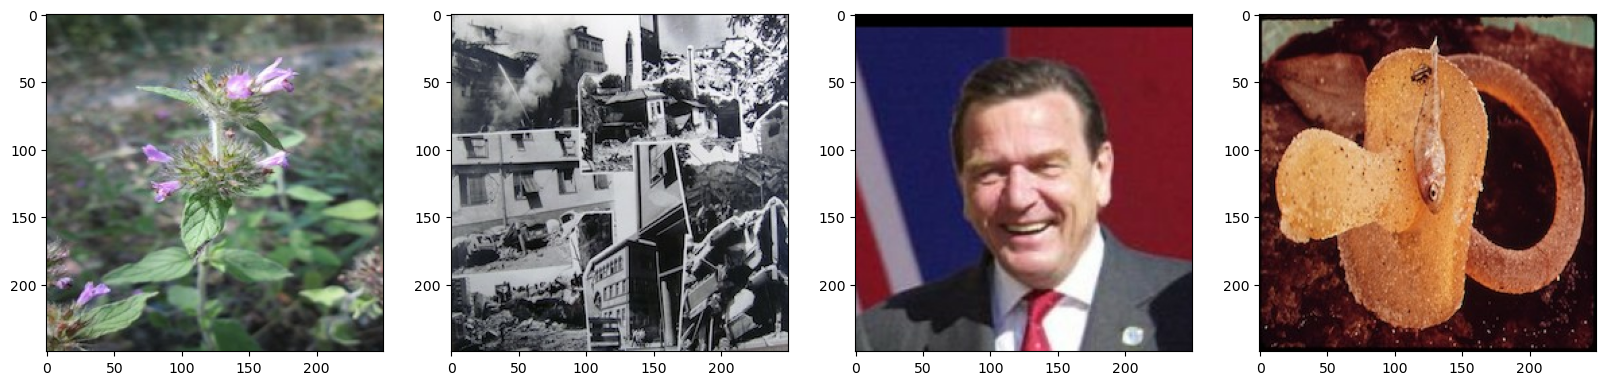

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(image_generator.next()):
    ax[idx].imshow(image) 
plt.show()

## Split into Training/Validation/Test Sets

Split into 0.7 / 0.15 / 0.15 (Train / Val / Test)

In [9]:
root_dir = 'data'
image_src = 'data/images'
label_src = 'data/labels'

for dir_name in ['train', 'val', 'test']:
    os.makedirs(root_dir +'/'+dir_name)
    os.makedirs(root_dir +'/'+dir_name+'/images')
    os.makedirs(root_dir +'/'+dir_name+'/labels')

In [10]:
allFileNames = os.listdir(image_src)
allFileNames = [name.split('.jpg')[0] for name in allFileNames]
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])

In [11]:
file_dict = {k:{} for k in ['train', 'val', 'test']}

In [12]:
file_dict

{'train': {}, 'val': {}, 'test': {}}

In [13]:
file_dict['train']['images'] = [image_src +'/'+ name + '.jpg' for name in train_FileNames.tolist()]
file_dict['val']['images'] = [image_src +'/' + name + '.jpg' for name in val_FileNames.tolist()]
file_dict['test']['images'] = [image_src +'/' + name + '.jpg' for name in test_FileNames.tolist()]

file_dict['train']['labels'] = [label_src+'/'+ name + '.json' for name  in train_FileNames.tolist()]
file_dict['val']['labels'] = [label_src+'/' + name + '.json' for name  in val_FileNames.tolist()]
file_dict['test']['labels'] = [label_src+'/' + name + '.json' for name  in test_FileNames.tolist()]

In [14]:
for dir_name in ['train', 'val', 'test']:
    for image_name, label_name in zip(file_dict[dir_name]['images'], file_dict[dir_name]['labels']):
        shutil.copy(image_name, f'Data/{dir_name}/images')
        try:
            shutil.copy(label_name, f'Data/{dir_name}/labels')
        except:
            # image does not contain a face
            pass

## Augmentation Pipeline

In [17]:
# Create Directory Structure for augmented data

In [9]:
root_dir = 'aug_data'
os.makedirs(root_dir)
for dir_name in ['train', 'val', 'test']:
    os.makedirs(root_dir +'/'+dir_name)
    os.makedirs(root_dir +'/'+dir_name+'/images')
    os.makedirs(root_dir +'/'+dir_name+'/labels')

In [10]:
transform = A.Compose([A.RandomCrop(width=200, height=200), 
                       A.HorizontalFlip(p=0.5), 
                       A.RandomBrightnessContrast(p=0.2),
                       A.RandomGamma(p=0.2), 
                       A.RGBShift(p=0.2), 
                       A.VerticalFlip(p=0.5)], 
                      bbox_params=A.BboxParams(format='albumentations', 
                                               label_fields=['class_labels']))

In [11]:
img = cv2.imread(os.path.join('data','train', 'images','Bill_Gates_0004.jpg'))
with open(os.path.join('data', 'train', 'labels', 'Bill_Gates_0004.json'), 'r') as f:
    label = json.load(f)
    
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
h, w, _ = img.shape
coords = list(np.divide(coords, [w,h,w,h]))

coords

[0.32014457831325294,
 0.12650602409638553,
 0.8526746987951807,
 0.8012048192771084]

In [17]:
augmented = transform(image=img, bboxes=[coords], class_labels=['face'])

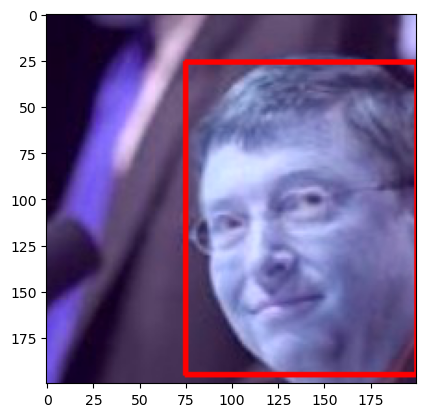

In [18]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [200,200]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [200,200]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [19]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            h, w, _ = img.shape
            coords = list(np.divide(coords, [w,h,w,h]))

        try: 
            for x in range(60):
                augmented = transform(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.7189397590361446, 0.2048192771084337, 0.30809638554216867, 0.8240963855421686, 'face'].
x_max is less than or equal to x_min for bbox [0.700867469879518, 0.17710843373493976, 0.3093012048192771, 0.8289156626506023, 'face'].
x_max is less than or equal to x_min for bbox [0.6755662650602409, 0.12168674698795179, 0.17556626506024095, 0.8108433734939758, 'face'].
x_max is less than or equal to x_min for bbox [0.7141204819277108, 0.17108433734939757, 0.26472289156626505, 0.7590361445783131, 'face'].
x_max is less than or equal to x_min for bbox [0.7249638554216867, 0.19156626506024094, 0.2948433734939759, 0.7566265060240963, 'face'].
x_max is less than or equal to x_min for bbox [0.7466506024096385, 0.061445783132530116, 0.22134939759036143, 0.8048192771084337, 'face'].
x_max is less than or equal to x_min for bbox [0.6791807228915663, 0.20120481927710843, 0.32375903614457824, 0.7867469879518071, 'face'].
x_max is less than or equal to x_min 

## Load Augmented Images into TensorFlow Dataset

In [20]:
image_data = []
for dir_name in ['train', 'val', 'test']:
    path = os.path.join('aug_data', dir_name, 'images', '*.jpg')
    temp = tf.data.Dataset.list_files(path, shuffle=False)
    temp = temp.map(load_image)
    temp = temp.map(lambda x: tf.image.resize(x, (120,120)))
    temp = temp.map(lambda x: x/255)
    
    image_data.append(temp)

In [21]:
train_images, val_images, test_images = image_data

# Prepare Labels

In [22]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [23]:
label_data = []
for dir_name in ['train', 'val', 'test']:
    path = os.path.join('aug_data', dir_name, 'labels', '*.json')
    temp = tf.data.Dataset.list_files(path, shuffle=False)
    temp = temp.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
    
    label_data.append(temp)

In [24]:
train_labels, val_labels, test_labels = label_data

In [25]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7080, 7080, 1560, 1560, 1560, 1560)

# Combine Label and Image Samples

In [26]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [27]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [28]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [29]:
train.as_numpy_iterator().next()[1]

2022-09-12 01:58:53.485995: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.3318 , 0.2776 , 0.865  , 0.9644 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2068 , 0.035  , 0.716  , 0.734  ],
        [0.1764 , 0.01313, 0.8105 , 0.852  ],
        [0.2214 , 0.2224 , 0.717  , 0.9136 ],
        [0.3406 , 0.0882 , 0.859  , 0.808  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


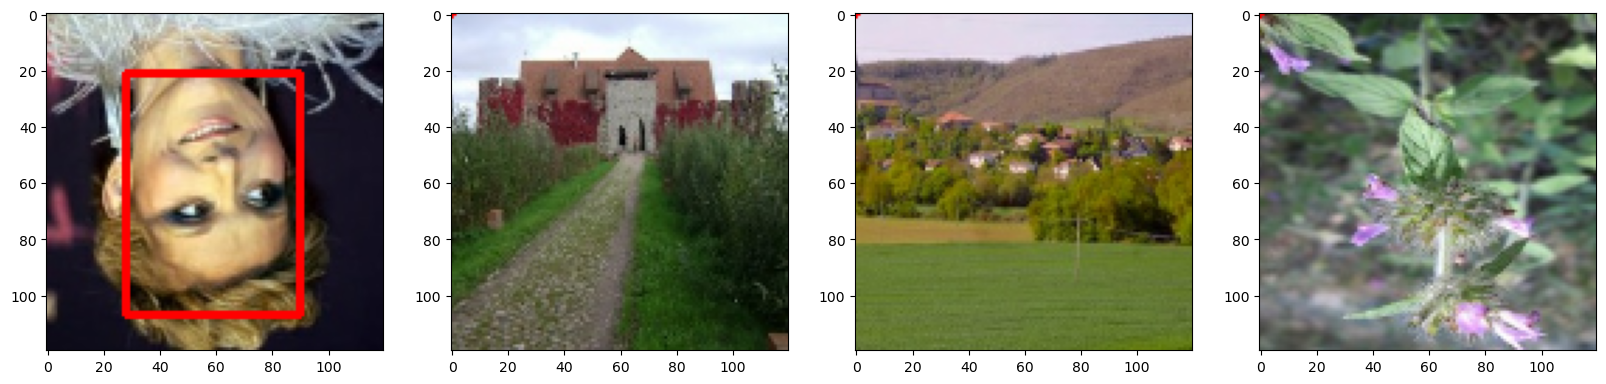

In [33]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning Model

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [35]:
vgg = VGG16(include_top=False)

In [36]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [37]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [38]:
facetracker = build_model()

In [39]:
X, y = train.as_numpy_iterator().next()

In [40]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 0s 142ms/step


2022-09-12 01:59:58.086354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(array([[0.7994661 ],
        [0.7555808 ],
        [0.80869406],
        [0.8933982 ],
        [0.81310445],
        [0.65858465],
        [0.5974934 ],
        [0.7587298 ]], dtype=float32),
 array([[0.63161904, 0.4887934 , 0.39985132, 0.7247675 ],
        [0.5531426 , 0.47082332, 0.36278155, 0.64722013],
        [0.57866955, 0.45494753, 0.3802425 , 0.5822618 ],
        [0.66022784, 0.4628211 , 0.38795227, 0.58982956],
        [0.51694435, 0.5251595 , 0.30442968, 0.715085  ],
        [0.6394399 , 0.48137885, 0.32670885, 0.6234737 ],
        [0.55458266, 0.43203992, 0.32245782, 0.6373566 ],
        [0.6314688 , 0.54381496, 0.3908248 , 0.74173677]], dtype=float32))

# Optimizer and Loss Functions

In [41]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [42]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [43]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [44]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.129525>

In [45]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7391097>

In [46]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.129525>

In [47]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [48]:
model = FaceTracker(facetracker)

In [49]:
model.compile(opt, classloss, regressloss)

In [50]:
logdir='logs'

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [52]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2022-09-12 02:00:01.319377: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'binary_crossentropy/cond/output/_10'
2022-09-12 02:00:01.322079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


885/885 [==============================] - ETA: 0s - total_loss: 0.1156 - class_loss: 0.0212 - regress_loss: 0.1050

2022-09-12 02:01:36.033590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


885/885 [==============================] - 102s 107ms/step - total_loss: 0.1155 - class_loss: 0.0212 - regress_loss: 0.1049 - val_total_loss: 0.0884 - val_class_loss: 8.8547e-04 - val_regress_loss: 0.0880
Epoch 2/10
885/885 [==============================] - 99s 107ms/step - total_loss: 0.0078 - class_loss: 1.5795e-05 - regress_loss: 0.0078 - val_total_loss: 0.0873 - val_class_loss: 0.0066 - val_regress_loss: 0.0840
Epoch 3/10
885/885 [==============================] - 99s 107ms/step - total_loss: 0.0042 - class_loss: 5.0091e-06 - regress_loss: 0.0042 - val_total_loss: 0.0930 - val_class_loss: 0.0254 - val_regress_loss: 0.0803
Epoch 4/10
885/885 [==============================] - 99s 107ms/step - total_loss: 0.0031 - class_loss: 2.9220e-06 - regress_loss: 0.0031 - val_total_loss: 0.0446 - val_class_loss: 0.0031 - val_regress_loss: 0.0430
Epoch 5/10
885/885 [==============================] - 99s 107ms/step - total_loss: 0.0024 - class_loss: 1.6458e-06 - regress_loss: 0.0024 - val_total_

In [53]:
hist.history

{'total_loss': [0.010281587019562721,
  0.005357678979635239,
  0.004857567138969898,
  0.004266445524990559,
  0.002379888901486993,
  0.000731665815692395,
  0.0010457030730322003,
  0.001782050239853561,
  0.0008010766468942165,
  0.0010938907507807016],
 'class_loss': [1.4088343959883787e-05,
  2.520202087907819e-06,
  3.511757142860006e-07,
  8.262958317573066e-07,
  1.0845133147086017e-06,
  1.353059474240581e-06,
  1.983109996217536e-06,
  9.91554998108768e-07,
  1.1361567686662966e-07,
  4.4403073843568563e-05],
 'regress_loss': [0.01027454249560833,
  0.005356418900191784,
  0.004857391584664583,
  0.004266032483428717,
  0.002379346638917923,
  0.0007309892680495977,
  0.0010447115637362003,
  0.0017815544269979,
  0.000801019836217165,
  0.001071689184755087],
 'val_total_loss': [0.08842169493436813,
  0.08729323744773865,
  0.09301150590181351,
  0.04455704614520073,
  0.14121206104755402,
  0.0889376699924469,
  0.46561282873153687,
  0.07847241312265396,
  0.0586442798376

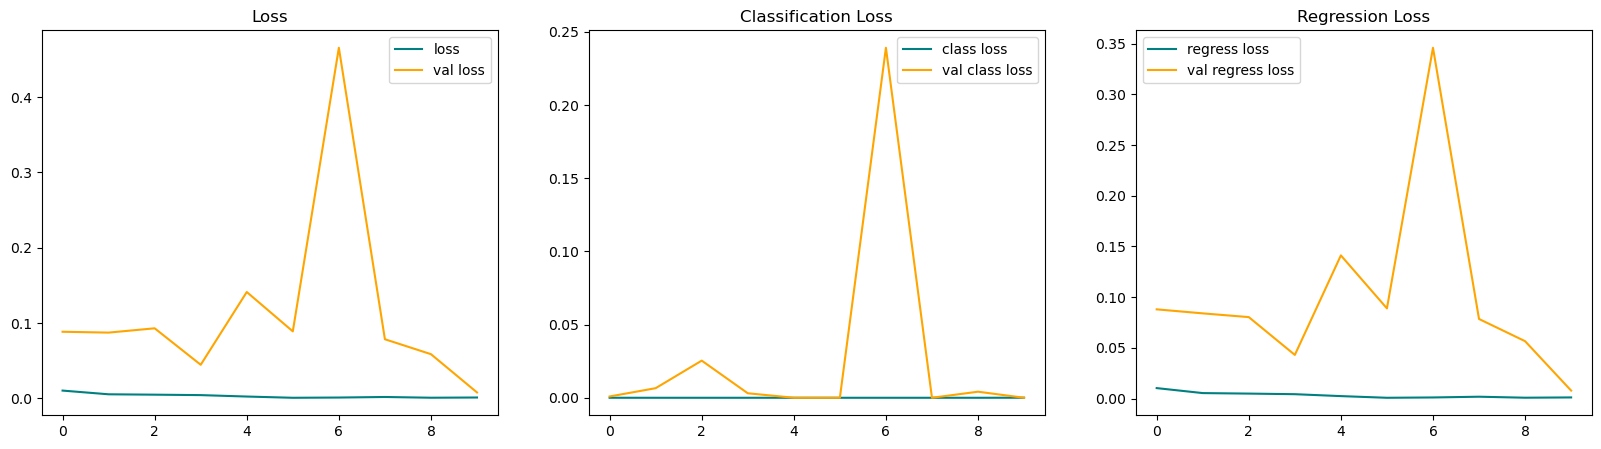

In [54]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Predictions

In [55]:
test_data = test.as_numpy_iterator()

In [59]:
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


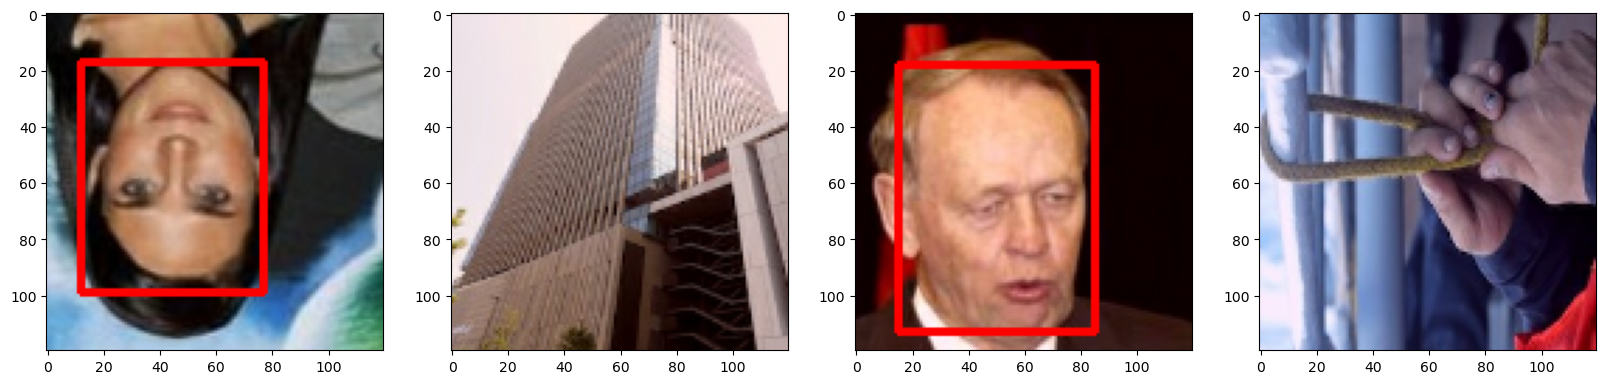

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Save Model

In [61]:
from tensorflow.keras.models import load_model

In [62]:
facetracker.save('facetracker.h5')